In [1]:
# dataset can be found from this link
# https://www.kaggle.com/datasets/vikrantrajput/lungs-disease-data

import tensorflow as tf
import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import pickle
import random as rnd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

import PIL as Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.models import Sequential
from keras.optimizers import Adamax

In [2]:
train_dir='lung_data/train'
filepath=[]
labels=[]
folds=os.listdir(train_dir)
for fold in folds:
    filpath=os.path.join(train_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath') 
l_series=pd.Series(labels,name='labels')
train_df=pd.concat([f_series,l_series],axis=1)


# Making a dataframe from the images by concatinating the label and an empty list with filepath

In [3]:
train_df.head()

,filepath,labels
0,lung_data/train\Healthy\01.jpeg,Healthy
1,lung_data/train\Healthy\010.jpeg,Healthy
2,lung_data/train\Healthy\011.jpeg,Healthy
3,lung_data/train\Healthy\012.jpeg,Healthy
4,lung_data/train\Healthy\013.jpeg,Healthy


In [4]:
test_dir='lung_data/test'
filepath=[]
labels=[]
folds=os.listdir(test_dir)
for fold in folds:
    filpath=os.path.join(test_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath') 
l_series=pd.Series(labels,name='labels')
test_df=pd.concat([f_series,l_series],axis=1)

In [5]:
test_df.head()

,filepath,labels
0,lung_data/test\healthy\0101.jpeg,healthy
1,lung_data/test\healthy\0102.jpeg,healthy
2,lung_data/test\healthy\0103.jpeg,healthy
3,lung_data/test\healthy\0105.jpeg,healthy
4,lung_data/test\healthy\0106.jpeg,healthy


In [6]:
count_train=train_df["labels"].value_counts()
count_train

labels
Type 1 disease    111
Healthy            70
Type 2 disease     70
Name: count, dtype: int64

In [7]:
count_test=test_df["labels"].value_counts()
count_test

labels
Type 1 disease    26
healthy           20
Type 2 disease    20
Name: count, dtype: int64

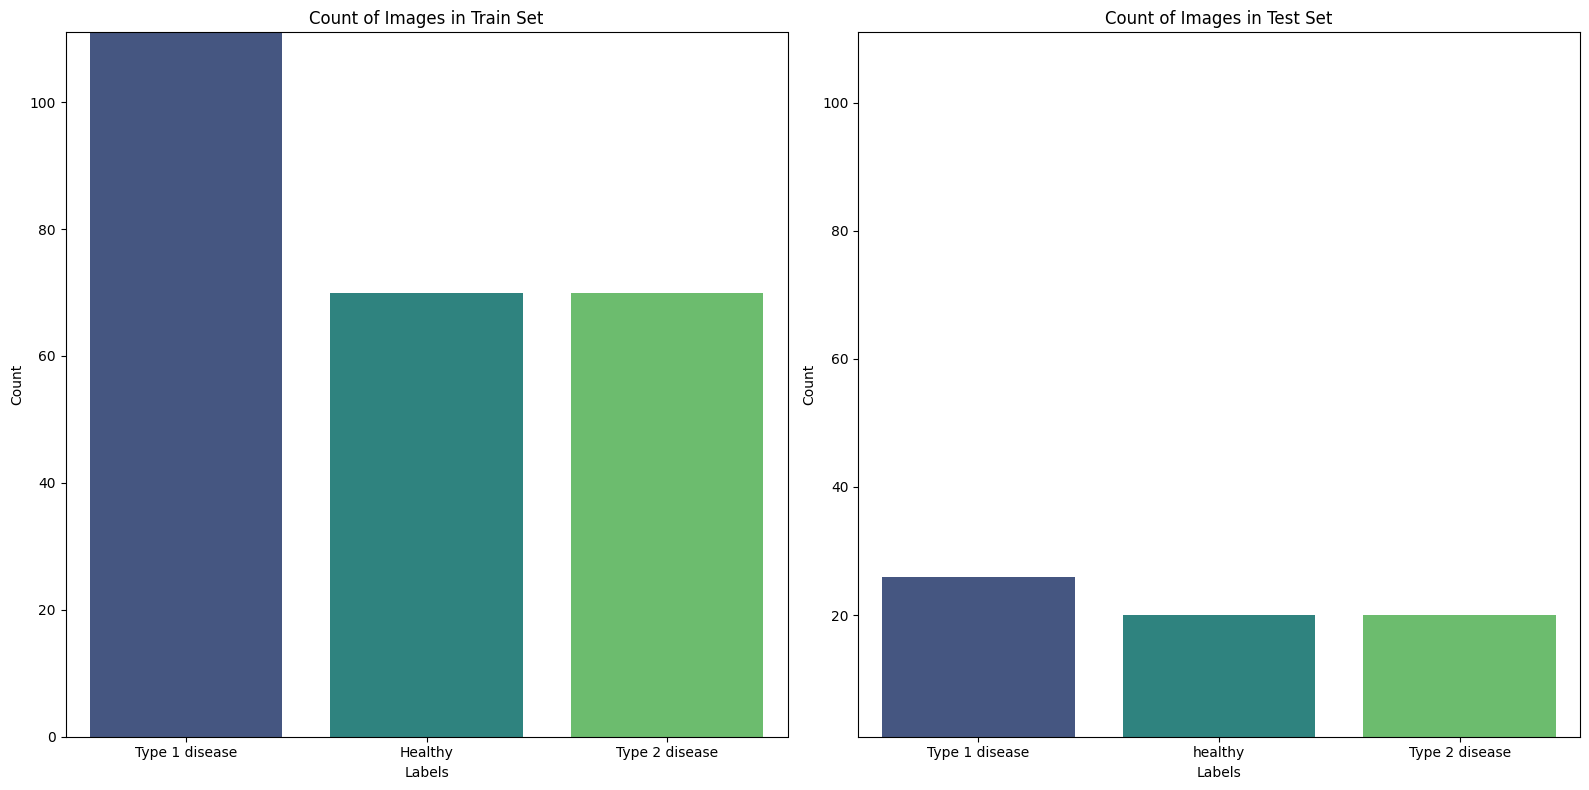

In [8]:
max_count = max(count_test.max(), count_train.max())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot test set count
sns.barplot(ax=axes[1], x=count_test.index, y=count_test.values, palette='viridis')
axes[1].set_title('Count of Images in Test Set')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Count')
axes[1].set_ylim(1, max_count)  # Set y-axis limits

# Plot train set count
sns.barplot(ax=axes[0], x=count_train.index, y=count_train.values, palette='viridis')
axes[0].set_title('Count of Images in Train Set')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max_count)  # Set y-axis limits

plt.tight_layout()
plt.show()

In [9]:
def preprocess(image_path, train, image_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255
    return image

In [10]:
def get_data(data_dir, train=True, image_size=48):
    data = [] 
    labels = []
    if train:
        path = os.path.join(data_dir, 'train')
    else:
        path = os.path.join(data_dir, 'test')
    for folder in os.listdir(path):
        if folder == ".DS_Store":
            continue
        image_dir = os.path.join(path, folder)
        for image in os.listdir(image_dir):
            if image == ".DS_Store":
                continue
            image_path = os.path.join(image_dir, image)
            
            image = preprocess(image_path, train, image_size)
            data.append(image)
            labels.append([folder])
    if train:
        datagen = ImageDataGenerator(
            rotation_range = 20,
            shear_range = 0.1,
            zoom_range = 0.1,
            horizontal_flip = False,)
        datagen.fit(data)
    return np.array(data), np.array(labels)

In [11]:
train_images, train_labels = get_data('lung_data', train= True)
test_images, test_labels = get_data('lung_data', train=False)
print(train_images.shape)
print(test_images.shape)

(251, 48, 48, 3)
(66, 48, 48, 3)


In [12]:
def show_rnd_images(images, labels):
    fig, ax = plt.subplots(5, 5, figsize=(25,25))
    for i in range(5):
        for j in range(5):
            rnd_int = rnd.randint(0, len(images)-1)
            ax[i,j].imshow(images[rnd_int],cmap='gray')
            ax[i,j].axis("off")
            ax[i,j].title.set_text(labels[rnd_int][0])
    plt.show()

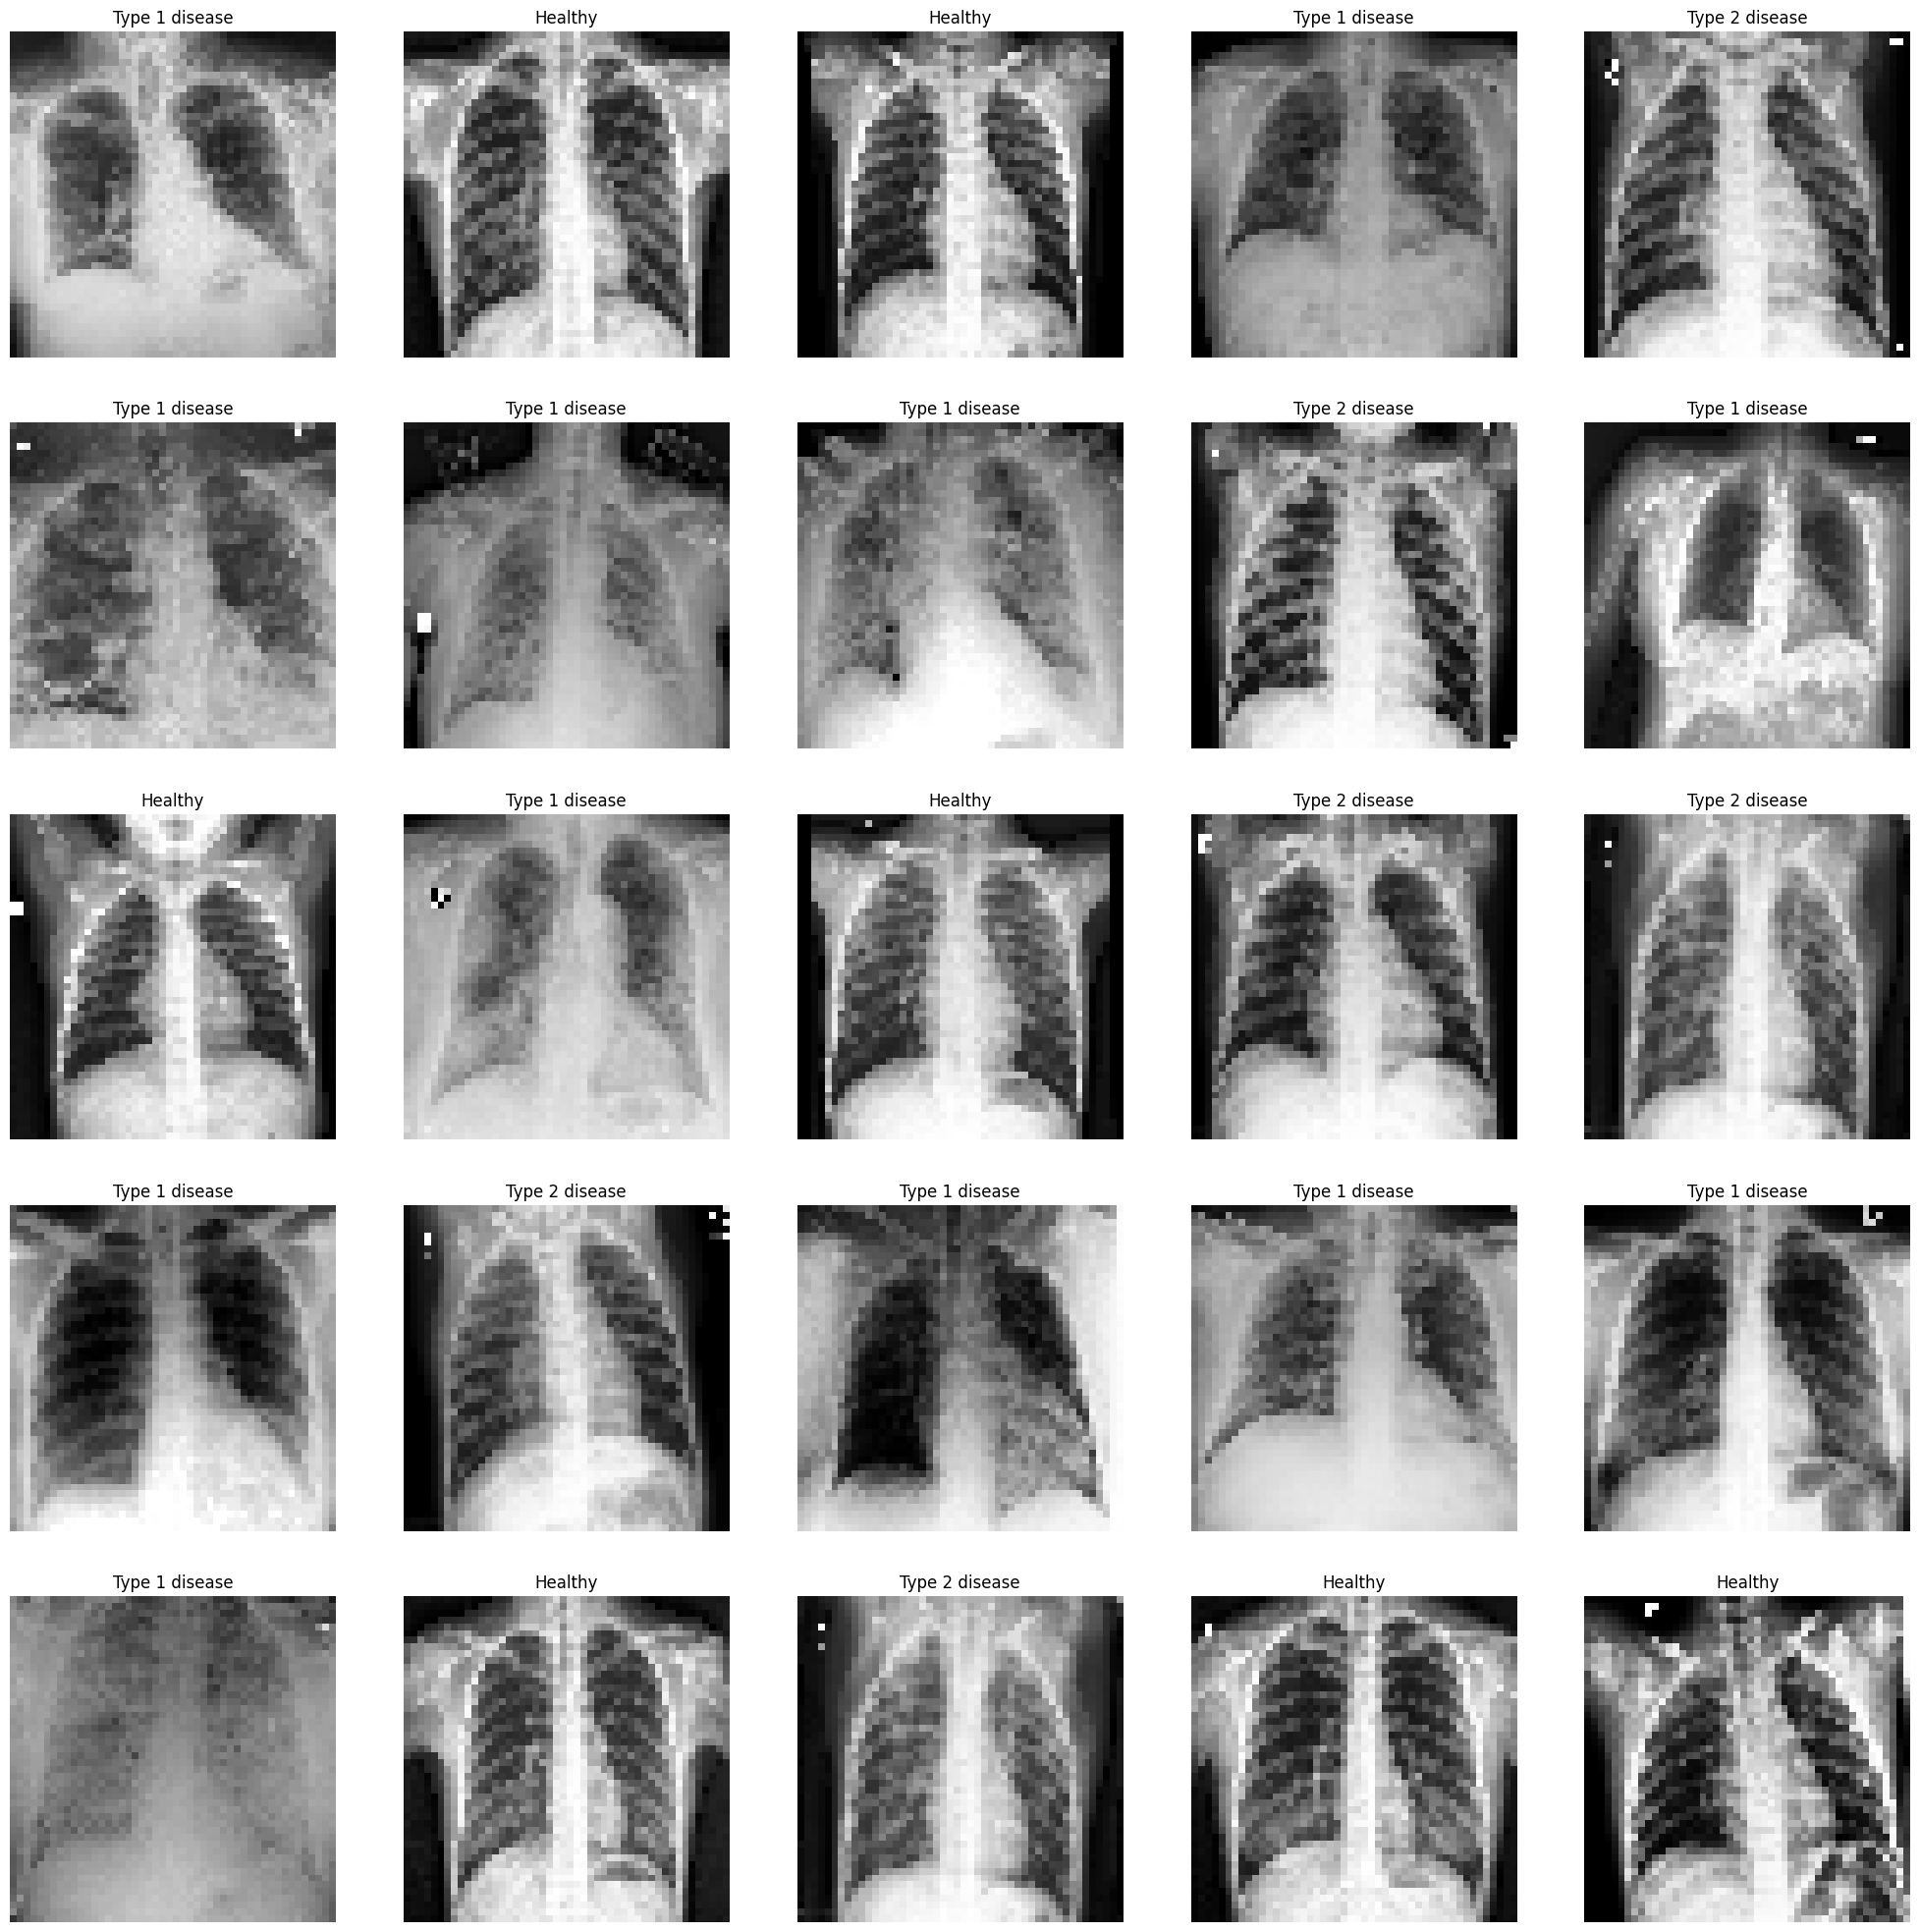

In [13]:
show_rnd_images(train_images, train_labels)

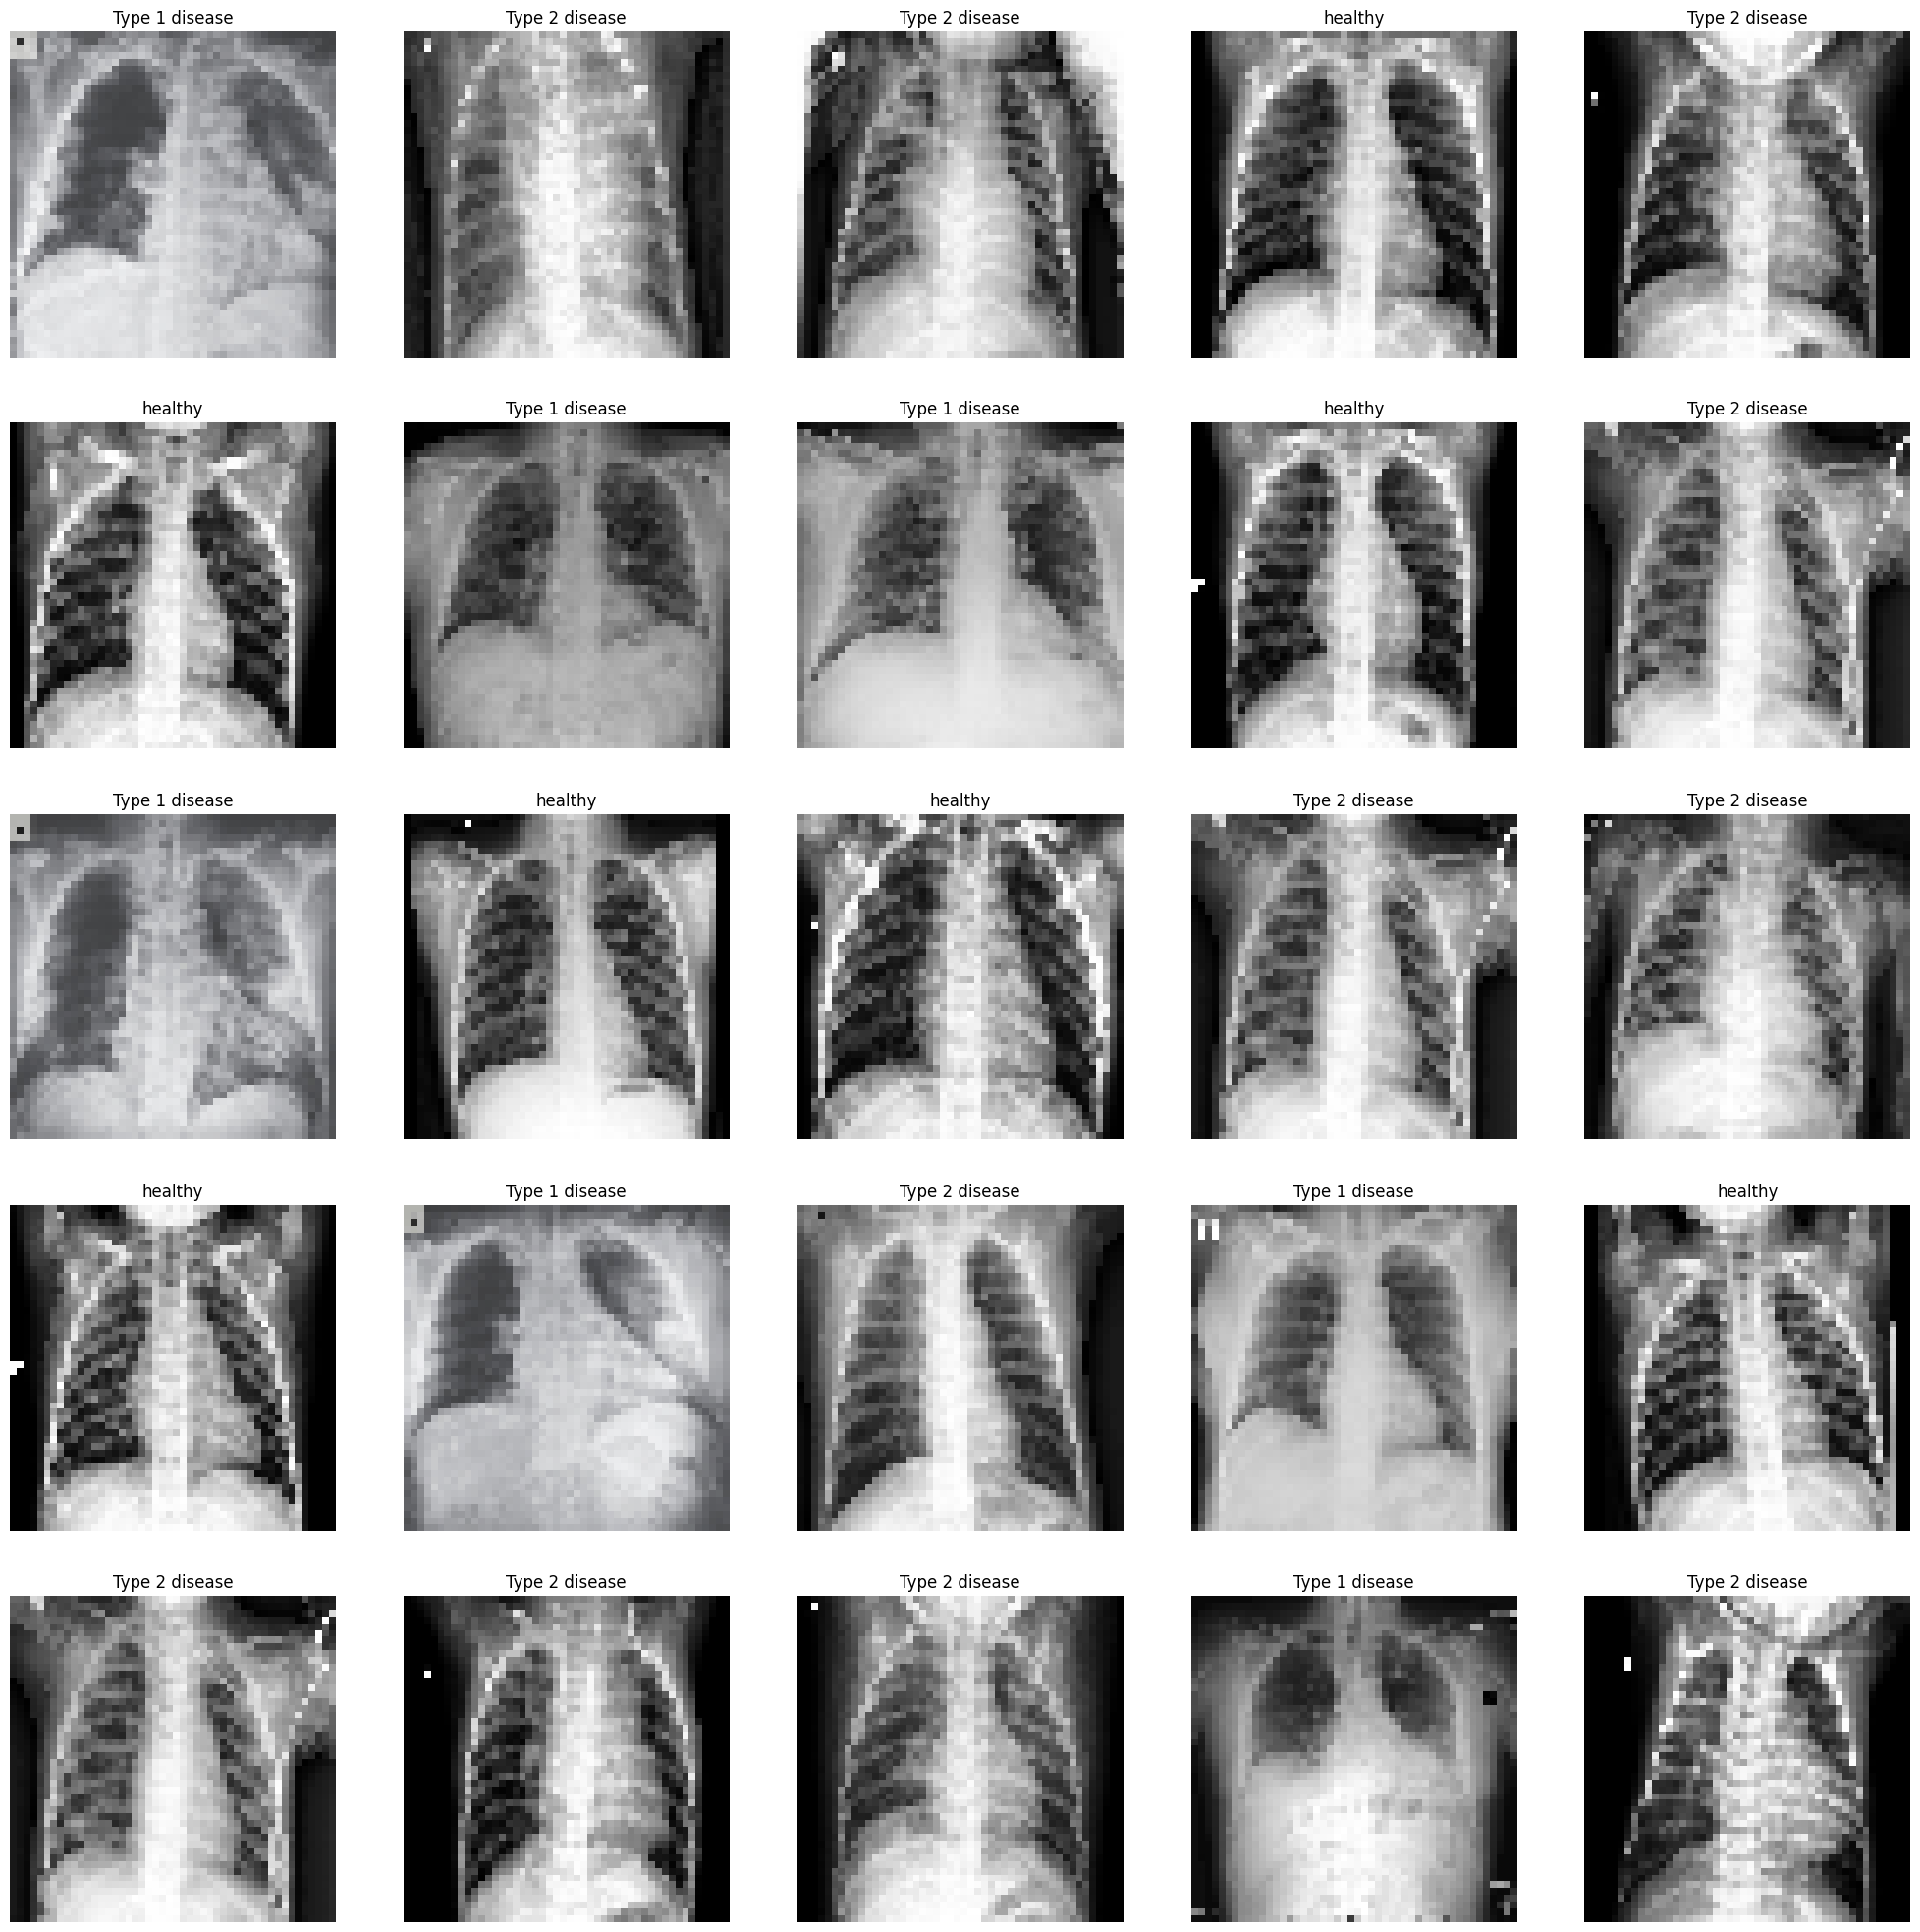

In [14]:
show_rnd_images(test_images, test_labels)

In [15]:
test_labels[test_labels == ["healthy"]] = ['Healthy']

In [16]:
train_images

array([[[[0.09019608, 0.09019608, 0.09019608],
         [0.16078431, 0.16078431, 0.16078431],
         [0.19215686, 0.19215686, 0.19215686],
         ...,
         [0.11764706, 0.11764706, 0.11764706],
         [0.14901961, 0.14901961, 0.14901961],
         [0.36078431, 0.36078431, 0.36078431]],

        [[0.10196078, 0.10196078, 0.10196078],
         [0.14509804, 0.14509804, 0.14509804],
         [0.22745098, 0.22745098, 0.22745098],
         ...,
         [0.16078431, 0.16078431, 0.16078431],
         [0.60392157, 0.60392157, 0.60392157],
         [0.36078431, 0.36078431, 0.36078431]],

        [[0.07843137, 0.07843137, 0.07843137],
         [0.15294118, 0.15294118, 0.15294118],
         [0.23529412, 0.23529412, 0.23529412],
         ...,
         [0.19607843, 0.19607843, 0.19607843],
         [0.38039216, 0.38039216, 0.38039216],
         [0.59215686, 0.59215686, 0.59215686]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [17]:
train_labels

array([['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],
       ['Healthy'],


In [18]:
# splitting to validation set
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.23, random_state=42)

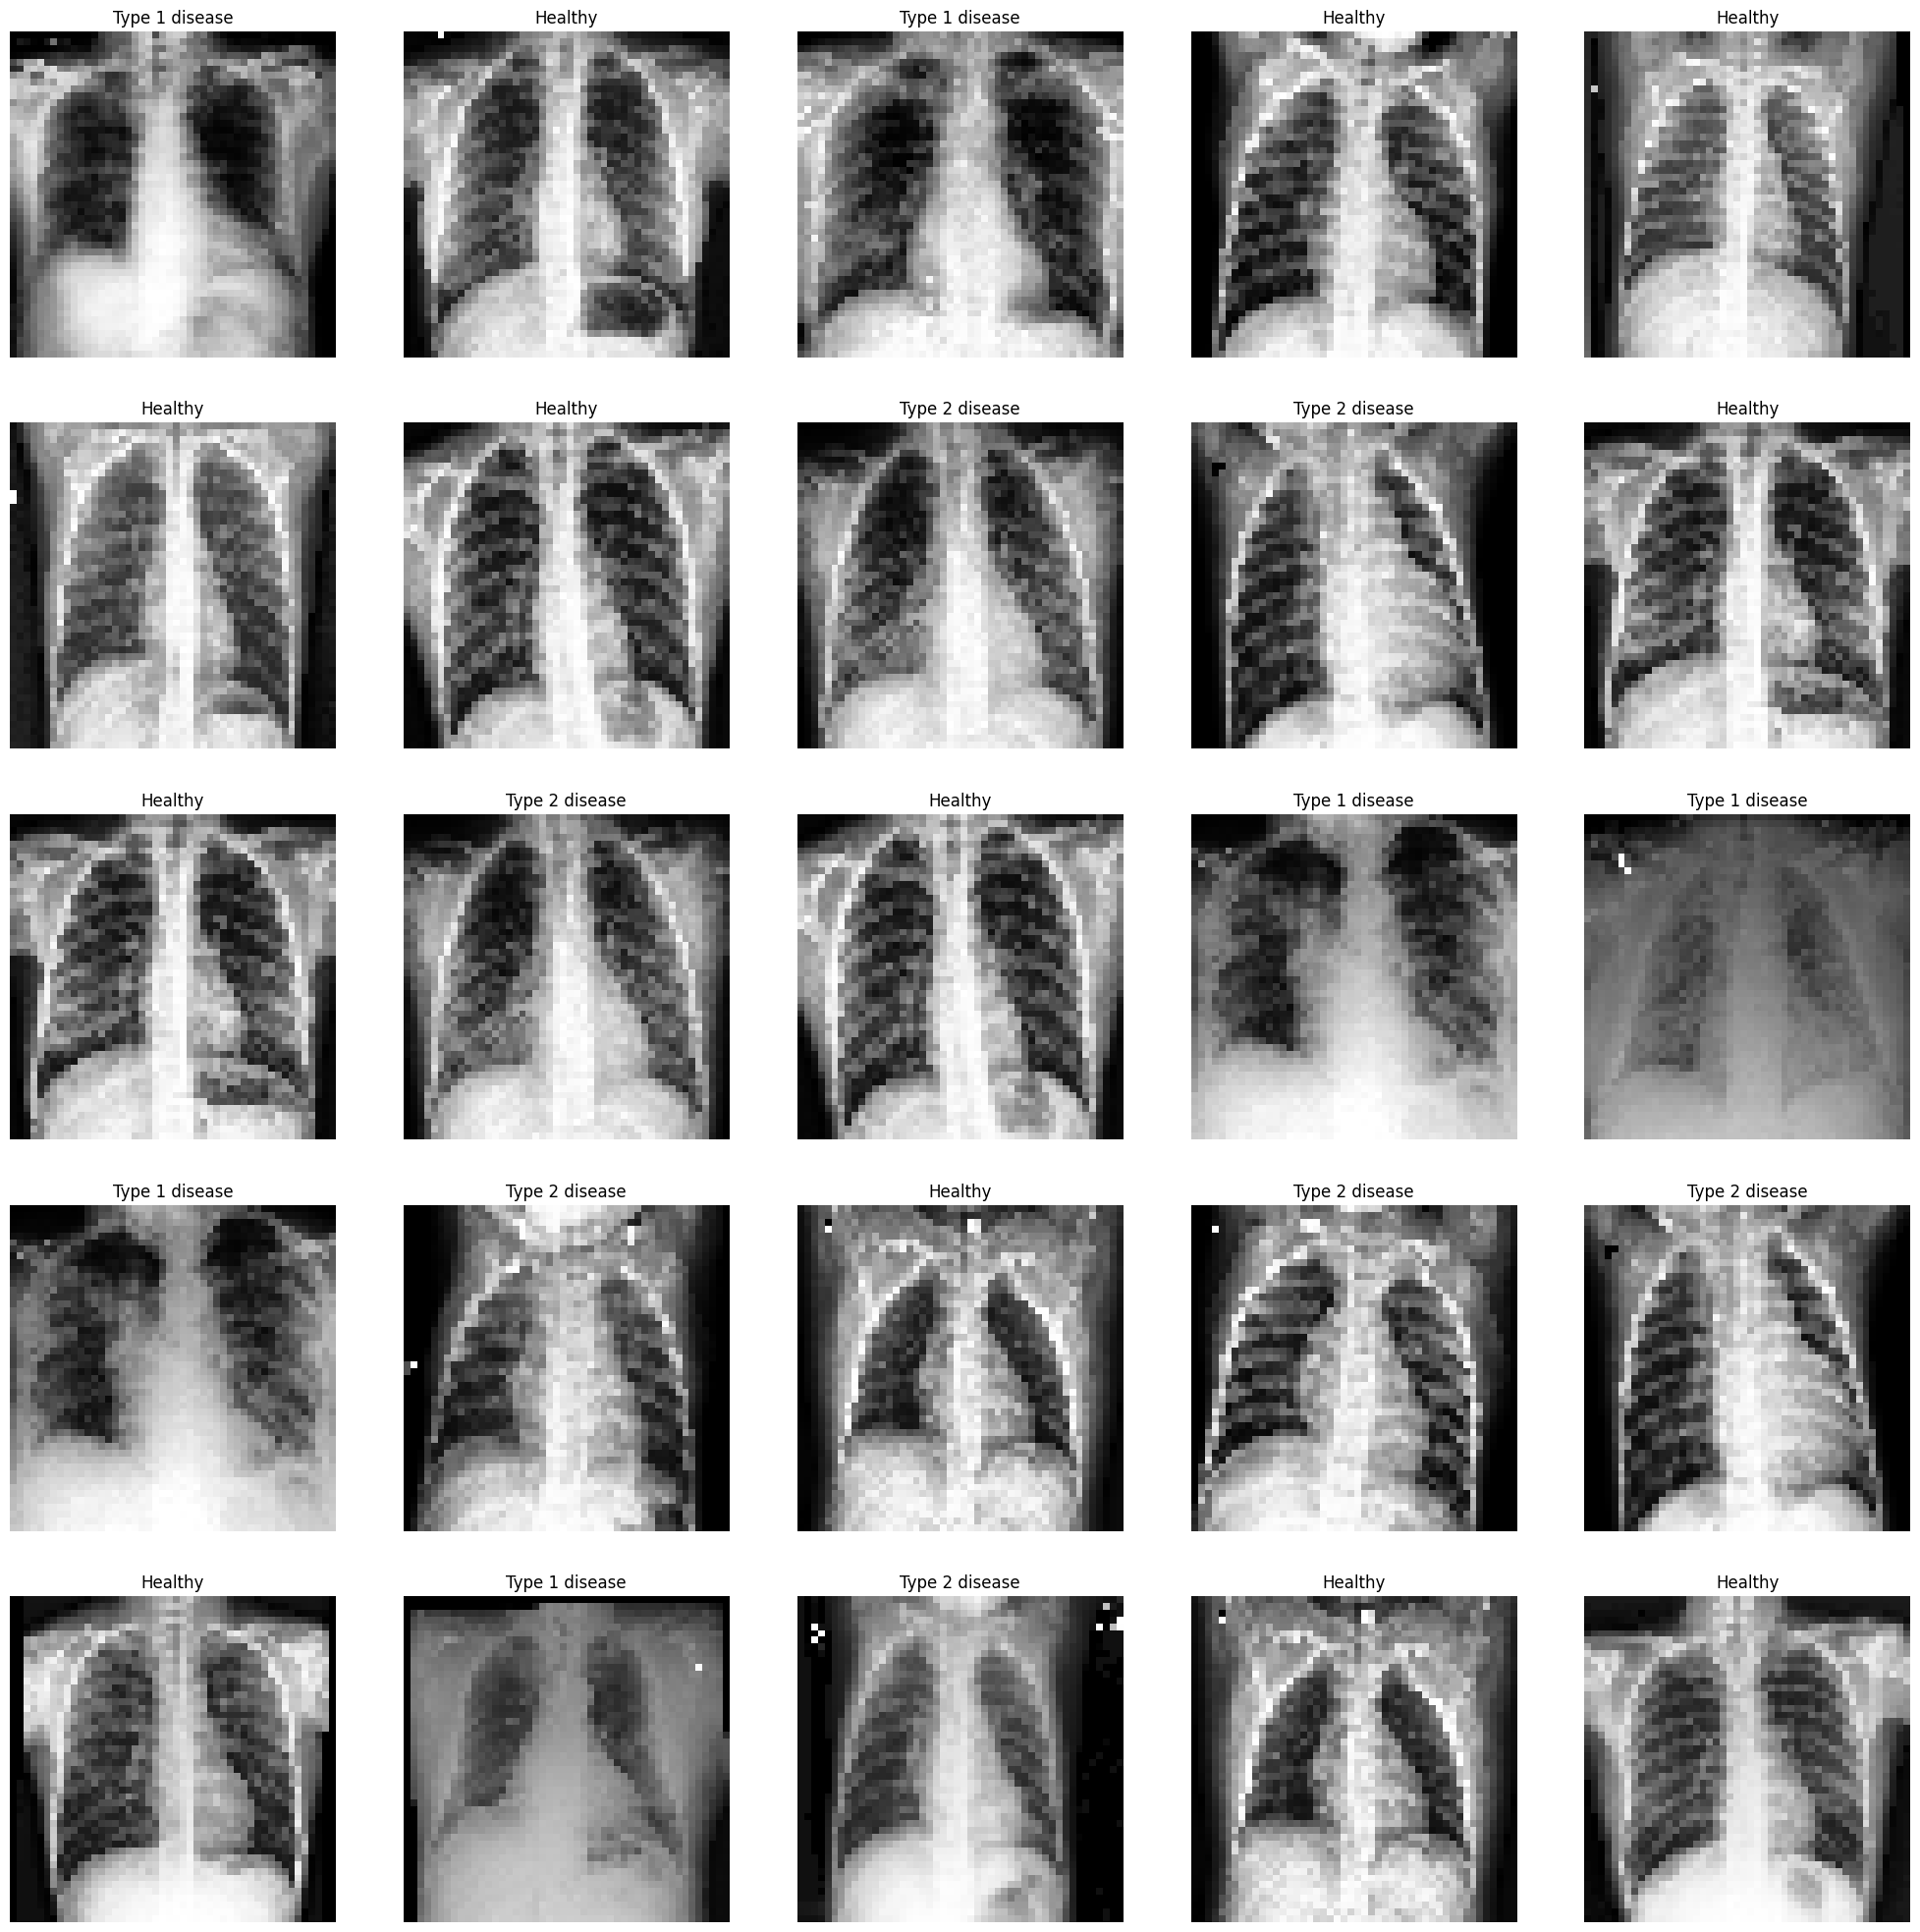

In [19]:
show_rnd_images(validation_images, validation_labels)

In [20]:
print("validation_set_percentage: ", round(len(validation_labels) / (51 + 200 + 66) * 100, 2))
print("train_set_percentage: ", round(len(train_labels) / (51 + 200 + 66) * 100, 2))
print("test_set_percentage: ", round(len(test_labels) / (51 + 200 + 66) * 100, 2))
# We see the percentages for each set size

validation_set_percentage:  18.3
train_set_percentage:  60.88
test_set_percentage:  20.82


In [21]:
test_labels.shape

(66, 1)

In [22]:
validation_labels.shape

(58, 1)

In [23]:
train_labels.shape

(193, 1)

In [24]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
train_labels = enc.fit_transform(train_labels).toarray()
test_labels = enc.transform(test_labels).toarray()
validation_labels = enc.transform(validation_labels).toarray()

# this transforms data from categorical to binaries

In [25]:
train_labels.shape

(193, 3)

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam, SGD

# Define the number of classes in your dataset
num_classes = 3
image_size = 48
# Define hyperparameters to see whihc one will be the best combination out of these 4.
# We would have 2^^4 - 16 combinations and plus manually writing epoch size, activation fucntion, 
# adding pooling, falttering
# loss will be calculated with cross entropy and as a metric we pick accuracy
optimizers = ['adam', 'sgd']
kernel_sizes = [(3, 3), (5, 5)]
filter_sizes = [64, 128]  
learning_rates = [0.001, 0.01]

# Initialize lists to store results
hyperparameter_combinations = []
accuracies = []
losses = []

# Iterate through all combinations of hyperparameters
for optimizer, kernel_size, filter_size, learning_rate in product(optimizers, kernel_sizes, filter_sizes, learning_rates):
    # Create and compile the model
    model = Sequential()
    model.add(Conv2D(filter_size, kernel_size=kernel_size, activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(num_classes, activation='softmax'))
    optimizer_instance = Adam() if optimizer == 'adam' else SGD()
    optimizer_instance.learning_rate = learning_rate  # Set the learning rate
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model
    history = model.fit(train_images, train_labels, 
                        validation_data=(validation_images, validation_labels), 
                        epochs=100)
    
    # Evaluate the model
    _, accuracy = model.evaluate(test_images, test_labels)
    
    # Store hyperparameters, accuracy, and loss
    hyperparameter_combinations.append((optimizer, kernel_size, filter_size, learning_rate))
    accuracies.append(accuracy)
    losses.append(np.mean(history.history['loss']))  # Compute the average loss across all epochs

# Convert lists to numpy arrays for visualization
accuracies = np.array(accuracies)
losses = np.array(losses)

# Plot the results
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.bar(range(len(hyperparameter_combinations)), accuracies, label='Accuracy')
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Hyperparameter Combinations')
plt.xticks(range(len(hyperparameter_combinations)), hyperparameter_combinations, rotation=90)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.bar(range(len(hyperparameter_combinations)), losses, label='Loss')
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Loss')
plt.title('Loss of Different Hyperparameter Combinations')
plt.xticks(range(len(hyperparameter_combinations)), hyperparameter_combinations, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Find the best hyperparameter combination
best_index = np.argmax(accuracies)
best_hyperparameters = hyperparameter_combinations[best_index]
best_accuracy = accuracies[best_index]
best_loss = losses[best_index]

print("Best hyperparameter combination: ", best_hyperparameters)
print("Best accuracy: ", best_accuracy)
print("Best loss: ", best_loss)

#
# Optimizer: An optimizer is a specific algorithm used to change the attributes of your neural network 
# such as weights and learning rate in order to minimize the losses. I used adam and SGD
#
# Kernel Size: It's the size of the convolutional filter.
#
# Filter Size: It determines the number of filters to apply in the convolutional layer
#
# Learning Rate: Learning rate is a hyperparameter that controls how much we are 
# adjusting the weights of our network with respect to the loss gradient
#
# epochs: number of times the entire dataset is passed forward and backward through the neural network
#
# Activation Function: Activation functions introduce non-linearities to the neural network, 
# allowing it to learn complex patterns in the data. You've used the ReLU activation function in 
# convolutional layers and the softmax activation function in the output layer.
# ReLU is widely used for its simplicity and effectiveness in combating the vanishing gradient problem,
# while softmax is commonly used for multi-class classification tasks as it converts raw scores into probabilities.
#
# Pooling layers reduce the spatial dimensions of the input data, which helps in reducing the 
# computational complexity and controlling overfitting by capturing the dominant features of the data
#
# Flattening is the process of converting the pooled feature map into a single column, 
# from multi-dimensional input into a one-dimensional array
#
# Dense layer is connecting all neurons

C:\Users\user\Anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3144 - loss: 1.2207 - val_accuracy: 0.5000 - val_loss: 1.0376
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5441 - loss: 0.9940 - val_accuracy: 0.5000 - val_loss: 0.9927
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5205 - loss: 0.8842 - val_accuracy: 0.6034 - val_loss: 0.8405
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6969 - loss: 0.6200 - val_accuracy: 0.7414 - val_loss: 0.5219
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8309 - loss: 0.3673 - val_accuracy: 0.8276 - val_loss: 0.4264
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8833 - loss: 0.3022 - val_accuracy: 0.8793 - val_loss: 0.3678
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9049 - loss: 0.2441 - val_accuracy: 0.9310 - val_loss: 0.2292
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9225 - loss: 0.1966 - val_accuracy: 0.9310 - val_loss:

Epoch 52/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9655 - val_loss: 0.2026
Epoch 53/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 6.1893e-04 - val_accuracy: 0.9655 - val_loss: 0.1948
Epoch 54/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 7.9724e-04 - val_accuracy: 0.9655 - val_loss: 0.1910
Epoch 55/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 6.4265e-04 - val_accuracy: 0.9655 - val_loss: 0.1992
Epoch 56/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 6.7606e-04 - val_accuracy: 0.9655 - val_loss: 0.1972
Epoch 57/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 7.0671e-04 - val_accuracy: 0.9655 - val_loss: 0.1875
Epoch 58/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 7.2314e-04 - val_accuracy: 0.9483 - val_loss: 0.1802
Epoch 59/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 6.4581e-0

KeyboardInterrupt: 

In [27]:
# loss is quite small but we need to work on improving accuracy
# As we have the model overfitting here, we must redice the number of epochs until 2 graphs meet.
# adding by hand padding, dropout rate, activation fucntions

In [27]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# here we add dropout level, padding, also change the size of epochs and polling method
# to see the difference in models when we test it
# Create the model


### adding newrons  in each layer as a hyperparameters
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=train_images.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())  

model.add(Dropout(0.5))
model.add(Dense(32)) # number of neurons
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(3))  # number of neurons, we have 3 classes at the end
model.add(Activation('sigmoid'))

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model with the specified optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)


In [28]:
history = model.fit(train_images, train_labels, 
                    validation_data=(validation_images, validation_labels), 
                    epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4047 - loss: 1.1165 - val_accuracy: 0.7586 - val_loss: 0.9732
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5578 - loss: 0.9801 - val_accuracy: 0.5690 - val_loss: 0.8143
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5910 - loss: 0.7998 - val_accuracy: 0.7931 - val_loss: 0.5532
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7516 - loss: 0.6140 - val_accuracy: 0.8276 - val_loss: 0.4634
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7597 - loss: 0.5647 - val_accuracy: 0.8621 - val_loss: 0.4035
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7886 - loss: 0.5170 - val_accuracy: 0.8793 - val_loss: 0.3668
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7889 - loss: 0.4752 - val_accuracy: 0.8966 - val_loss: 0.3259
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7777 - loss: 0.5432 - val_accuracy: 0.7069 - val_loss:

Epoch 52/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9577 - loss: 0.0808 - val_accuracy: 0.9655 - val_loss: 0.2291
Epoch 53/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9646 - loss: 0.0806 - val_accuracy: 0.9655 - val_loss: 0.2114
Epoch 54/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9704 - loss: 0.1001 - val_accuracy: 0.9483 - val_loss: 0.2409
Epoch 55/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9697 - loss: 0.0962 - val_accuracy: 0.9483 - val_loss: 0.1943
Epoch 56/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9668 - loss: 0.0956 - val_accuracy: 0.9655 - val_loss: 0.1842
Epoch 57/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9892 - loss: 0.0579 - val_accuracy: 0.9655 - val_loss: 0.2253
Epoch 58/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9702 - loss: 0.0741 - val_accuracy: 0.9655 - val_loss: 0.2209
Epoch 59/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9626 - loss: 0.0853 - val_accuracy: 0.9483 - v

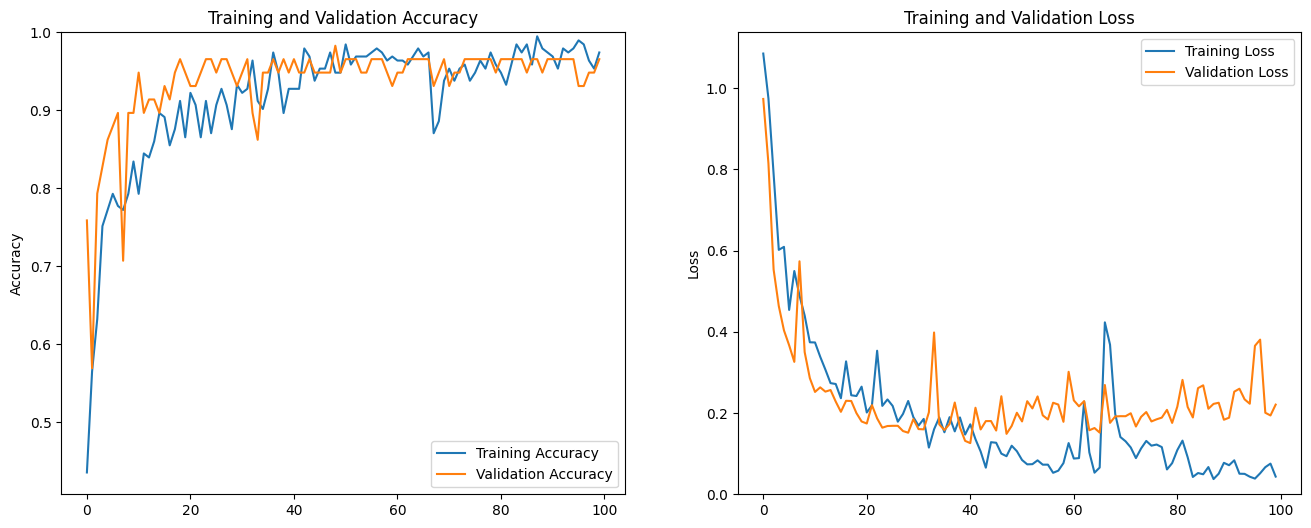

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [31]:

    
# we will train each model multiple times to see the difference in 2 models
# one has avgerage pooling, different filter size and different num of neurons
# one has max pooling, different filter size and different num of neurons

In [30]:
# adding/changing hyperparameters
np.random.seed(42)

# Create a new TensorFlow session for each run
for seed in range(42):
    tf.keras.backend.clear_session()  # Clear previous session
    tf.random.set_seed(seed)  # Set random seed for TensorFlow
    np.random.seed(seed)  # Set random seed for NumPy

In [31]:
from keras.layers import AveragePooling2D

# Create the model
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=train_images.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())  

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('sigmoid'))

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model with the specified optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

history = model.fit(train_images, train_labels, 
                    validation_data=(validation_images, validation_labels), 
                    epochs=25)

print(f"Run {seed+1}:")
print(f"  - Training Accuracy: {history.history['accuracy'][-1]}")
print(f"  - Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"  - Training Loss: {history.history['loss'][-1]}")
print(f"  - Validation Loss: {history.history['val_loss'][-1]}")


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.3598 - loss: 1.1186 - val_accuracy: 0.6724 - val_loss: 0.9866
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6091 - loss: 0.9865 - val_accuracy: 0.5517 - val_loss: 0.8663
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6164 - loss: 0.8474 - val_accuracy: 0.8621 - val_loss: 0.5987
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7337 - loss: 0.6722 - val_accuracy: 0.8103 - val_loss: 0.5250
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7204 - loss: 0.5635 - val_accuracy: 0.8793 - val_loss: 0.3695
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8021 - loss: 0.5746 - val_accuracy: 0.8966 - val_loss: 0.3730
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7947 - loss: 0.4950 - val_accuracy: 0.9138 - val_loss: 0.3639
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7834 - loss: 0.4601 - val_accuracy: 0.8966 - val_loss: 0.3158


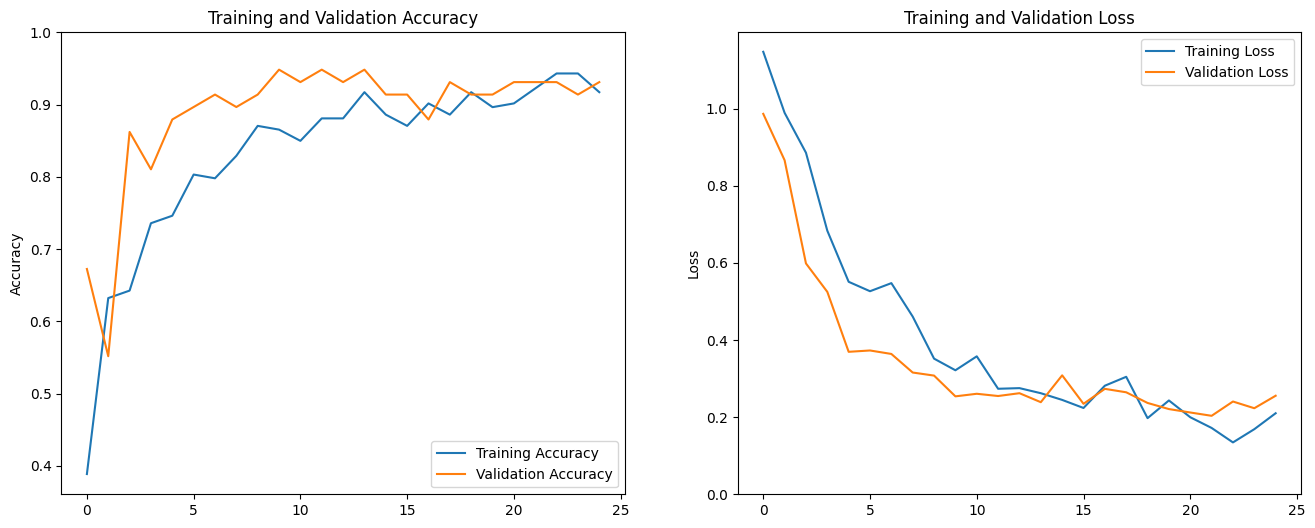

Highest Accuracy: 0.9430052042007446
Highest Vlidation Accuracy: 0.9482758641242981
Lowest Loss: 0.13451234996318817
Lowest Vlidation Loss: 0.20352497696876526


In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()
highest_accuracy = max(acc)
highest_val_accuracy = max(val_acc)
lowest_loss = min(loss)
lowest_val_loss = min(val_loss)
print("Highest Accuracy:", highest_accuracy)
print("Highest Vlidation Accuracy:", highest_val_accuracy)
print("Lowest Loss:", lowest_loss)
print("Lowest Vlidation Loss:", lowest_val_loss)

In [33]:
train_loss, train_accuracy = model.evaluate(train_images, train_labels, steps = 20, verbose = 1)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
# only the first 20 batches of the dataset will be used for evaluation, rather than the entire dataset.
# This can be useful for quickly evaluating the model's performance on a subset of the data.
# evaluating the model bay steps , lossfor train and validation shall be as low as possible
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_images, validation_labels, steps = 20 , verbose = 1)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9517 - loss: 0.1333
Training Loss: 0.12796975672245026
Training Accuracy: 0.9533678889274597
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9751 - loss: 0.1591
Validation Loss: 0.24319615960121155
Validation Accuracy: 0.931034505367279


In [34]:
def prediction(images):
    y_pred = []
    for i in model.predict(images).argmax(axis=1):
        tmp = [0., 0., 0.]
        tmp[i] = 1.
        y_pred.append(tmp)
    y_pred = enc.inverse_transform(y_pred)
    return y_pred

In [35]:
y_pred = prediction(test_images)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [36]:
y_true = enc.inverse_transform(test_labels)

In [37]:
confusion_matrix(y_true, y_pred)
# predicting the values for 2 disseases and healthy labels

array([[16,  0,  4],
       [ 1, 25,  0],
       [ 1,  2, 17]], dtype=int64)

In [38]:
print(classification_report(y_true, y_pred))

                precision    recall  f1-score   support

       Healthy       0.89      0.80      0.84        20
Type 1 disease       0.93      0.96      0.94        26
Type 2 disease       0.81      0.85      0.83        20

      accuracy                           0.88        66
     macro avg       0.87      0.87      0.87        66
  weighted avg       0.88      0.88      0.88        66



In [35]:
#max pooling

In [39]:
for seed in range(42):
    tf.keras.backend.clear_session()  # Clear previous session
    tf.random.set_seed(seed)  # Set random seed for TensorFlow
    np.random.seed(seed)  # Set random seed for NumPy

In [64]:
from keras.layers import AveragePooling2D

# Create the model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=train_images.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())  

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('sigmoid'))

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model with the specified optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

history = model.fit(train_images, train_labels, 
                    validation_data=(validation_images, validation_labels), 
                    epochs=25)

print(f"Run {seed+1}:")
print(f"  - Training Accuracy: {history.history['accuracy'][-1]}")
print(f"  - Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"  - Training Loss: {history.history['loss'][-1]}")
print(f"  - Validation Loss: {history.history['val_loss'][-1]}")



Epoch 1/25


C:\Users\user\Anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3843 - loss: 1.1589 - val_accuracy: 0.6379 - val_loss: 0.9685
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4899 - loss: 0.9925 - val_accuracy: 0.5862 - val_loss: 0.8687
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5970 - loss: 0.9029 - val_accuracy: 0.7586 - val_loss: 0.7269
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6885 - loss: 0.7767 - val_accuracy: 0.8103 - val_loss: 0.6016
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7542 - loss: 0.6707 - val_accuracy: 0.9310 - val_loss: 0.4723
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7461 - loss: 0.5786 - val_accuracy: 0.8103 - val_loss: 0.4891
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7634 - loss: 0.4923 - val_accuracy: 0.9138 - val_loss: 0.3352
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8320 - loss: 0.4493 - val_accuracy: 0.9138 - val_loss: 0.3383
Epoch 9/25


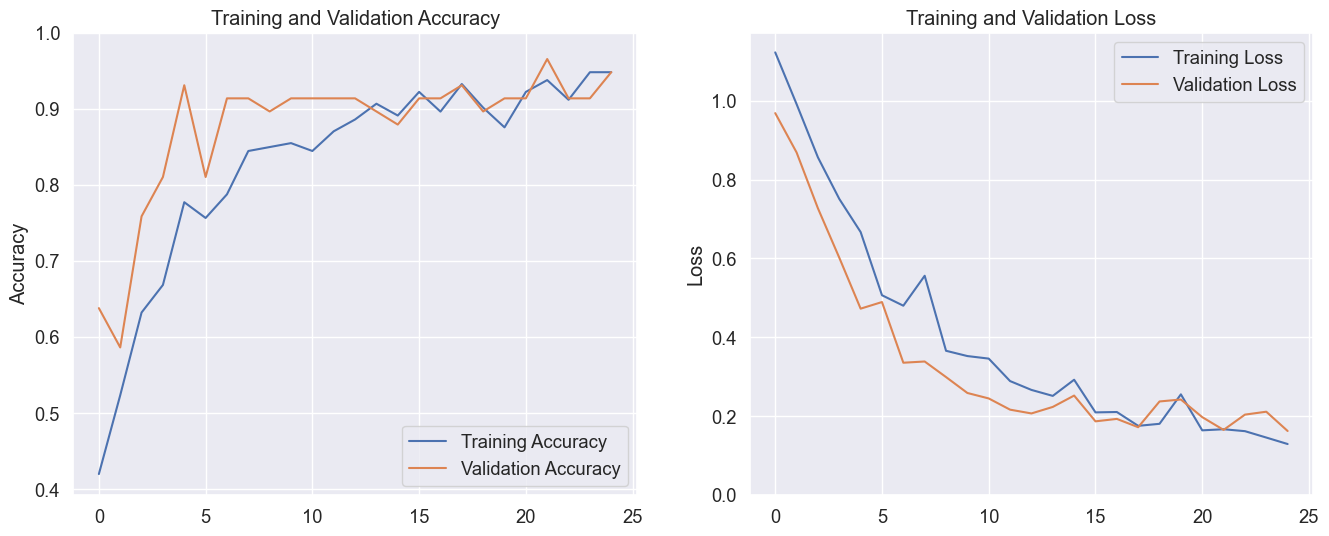

Highest Accuracy: 0.9481865167617798
Highest Vlidation Accuracy: 0.9655172228813171
Lowest Loss: 0.12885050475597382
Lowest Vlidation Loss: 0.16191568970680237


In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()
highest_accuracy = max(acc)
highest_val_accuracy = max(val_acc)
lowest_loss = min(loss)
lowest_val_loss = min(val_loss)
print("Highest Accuracy:", highest_accuracy)
print("Highest Vlidation Accuracy:", highest_val_accuracy)
print("Lowest Loss:", lowest_loss)
print("Lowest Vlidation Loss:", lowest_val_loss)

In [66]:
train_loss, train_accuracy = model.evaluate(train_images, train_labels, steps = 20, verbose = 1)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
# only the first 20 batches of the dataset will be used for evaluation, rather than the entire dataset.
# This can be useful for quickly evaluating the model's performance on a subset of the data.
# evaluating the model bay steps , loss for train and validation shall be as low as possible
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_images, validation_labels, steps = 20 , verbose = 1)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - loss: 0.0804
Training Loss: 0.06861758232116699
Training Accuracy: 0.984455943107605
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9618 - loss: 0.1162
Validation Loss: 0.15816383063793182
Validation Accuracy: 0.9482758641242981


In [67]:
def prediction(images):
    y_pred = []
    for i in model.predict(images).argmax(axis=1):
        tmp = [0., 0., 0.]
        tmp[i] = 1.
        y_pred.append(tmp)
    y_pred = enc.inverse_transform(y_pred)
    return y_pred
# Each prediction is converted into a one-hot encoded format and stored in a list

In [68]:
y_true = enc.inverse_transform(test_labels)

In [69]:
y_pred = prediction(test_images)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [70]:
confusion_matrix(y_true, y_pred)
# predicting the values for 2 disseases and healthy labels

array([[18,  0,  2],
       [ 0, 26,  0],
       [ 2,  0, 18]], dtype=int64)

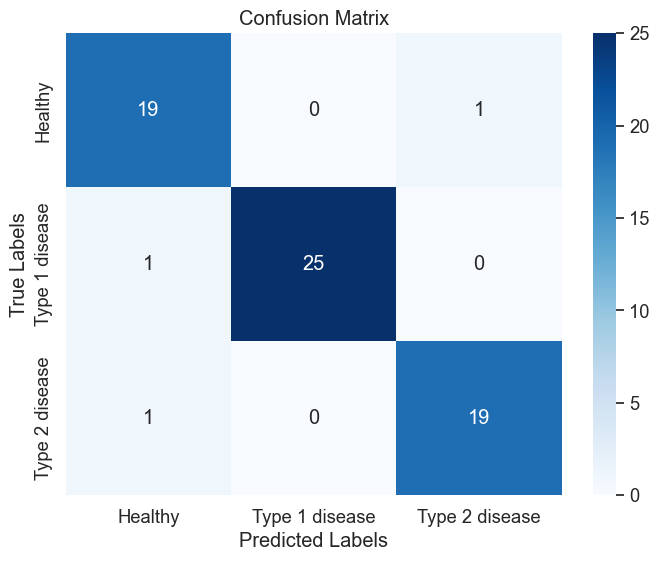

In [56]:
confusion_matrix_values = np.array([[19, 0, 1],
                                    [1, 25, 0],
                                    [1, 0, 19]])

# Define class labels
classes = ['Healthy', 'Type 1 disease', 'Type 2 disease']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
print(classification_report(y_true, y_pred))

                precision    recall  f1-score   support

       Healthy       0.91      1.00      0.95        20
Type 1 disease       0.96      0.96      0.96        26
Type 2 disease       1.00      0.90      0.95        20

      accuracy                           0.95        66
     macro avg       0.96      0.95      0.95        66
  weighted avg       0.96      0.95      0.95        66



In [45]:
# filter changes a lot

In [ ]:
# after running the model 5 times with avg pooling and max pooling 
# it shows that the max pooling gives better result with accuracy and loss

In [79]:
# Initializes a sequential model, which is a linear stack of layers.
# Conv2D(...), MaxPooling2D(...), Flatten(), Dense(...): These lines define the layers of the model. 
# The model architecture consists of multiple convolutional layers (Conv2D), 
# max pooling layers (MaxPooling2D), flattening layer (Flatten), and dense layers (Dense). 
# Each convolutional layer applies a set of filters to the input image to extract features, 
# max pooling layers downsample the feature maps, flattening layer converts the multi-dimensional 
# feature maps into a 1D vector, and dense layers perform classification based on the extracted features.


#model.compile(...): Configures the model for training. It specifies the optimizer, loss function, 
#and metrics to be used during training. In this case, the Adamax optimizer with a learning rate 
# of 0.001 is used, categorical crossentropy is chosen as the loss function for multi-class 
# classification, and accuracy is selected as the evaluation metric.

#model.summary(): Prints a summary of the model architecture, including the type and shape of each 
#layer, the number of parameters, and the output shape at each layer. This summary provides a concise 
#overview of the model's structure, which is helpful for debugging and optimizing the model.






# filters=256: This parameter specifies the number of filters (also referred to as kernels) that the 
# layer will use. Each filter detects different features in the input data. In this case, there will 
# be 256 filters applied to the input.
# kernel_size=(3,3): This parameter determines the size of the convolutional kernel (or filter). 
# It specifies the height and width of the 2D convolution window. In this case, each filter will 
# have a size of 3x3 pixels. A 3x3 kernel is a common choice for convolutional operations in CNNs.





# model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=[keras.metrics.AUC(from_logits=True)])
